# Import libraries

In [1]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
import os
import pandas as pd

#custom
from py.helper import DataProcessing
from py.ml_metrics import evaluate_model, multiclass_logloss
from py.plotting import plot_tsne

#global
sns.set(rc={'figure.figsize':(15,15)})

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# set K-mer length here
kmer = 4


In [3]:
rvdb14 = DataProcessing('RVDB14_complete_coronavirus_fixed.fasta', 'RVDB14_Coronavirus_meta_data_human_pathogen.csv')

# Load cleaned data

In [4]:
cleaned_path = os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv')

cleaned_df = pd.read_csv(cleaned_path, dtype={'label':int})
# remove nans
cleaned_df.dropna(inplace=True)

# remove artifacts
for index, row in cleaned_df.iterrows():
    if row['label'] < 0:
        cleaned_df.drop(index, inplace=True)
cleanded_df = cleaned_df[cleaned_df['label'] >= 0]
cleaned_df.head()

,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


Labels found: [0 1]


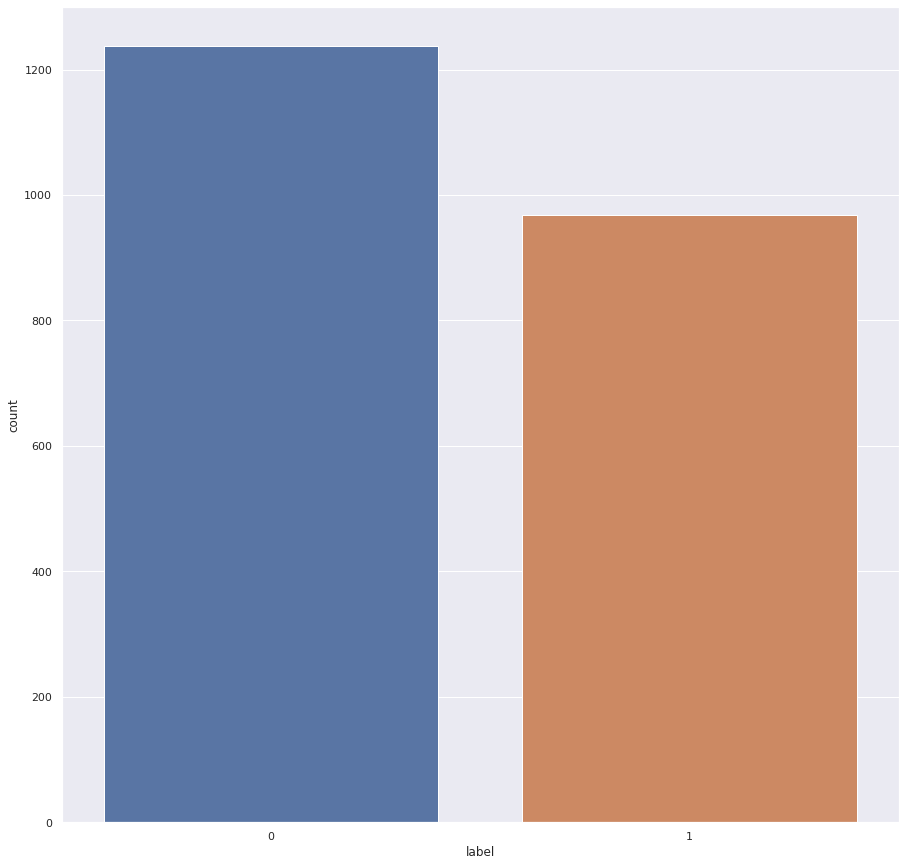

In [5]:
# biinary labels - sanity check 

print(f"Labels found: {cleaned_df['label'].unique()}")
sns.countplot(cleaned_df['label'])

In [6]:
# min and max length of sequences
max_len = max(len(s) for s in cleaned_df['seq'])
min_len =min(len(s) for s in cleaned_df['seq'])
print(f"Sequence length - max:{max_len}, min:{min_len}")

Sequence length - max:31775, min:25320


# No class imbalance in the distribution of sequence lengths

## 1. Whole Dataset

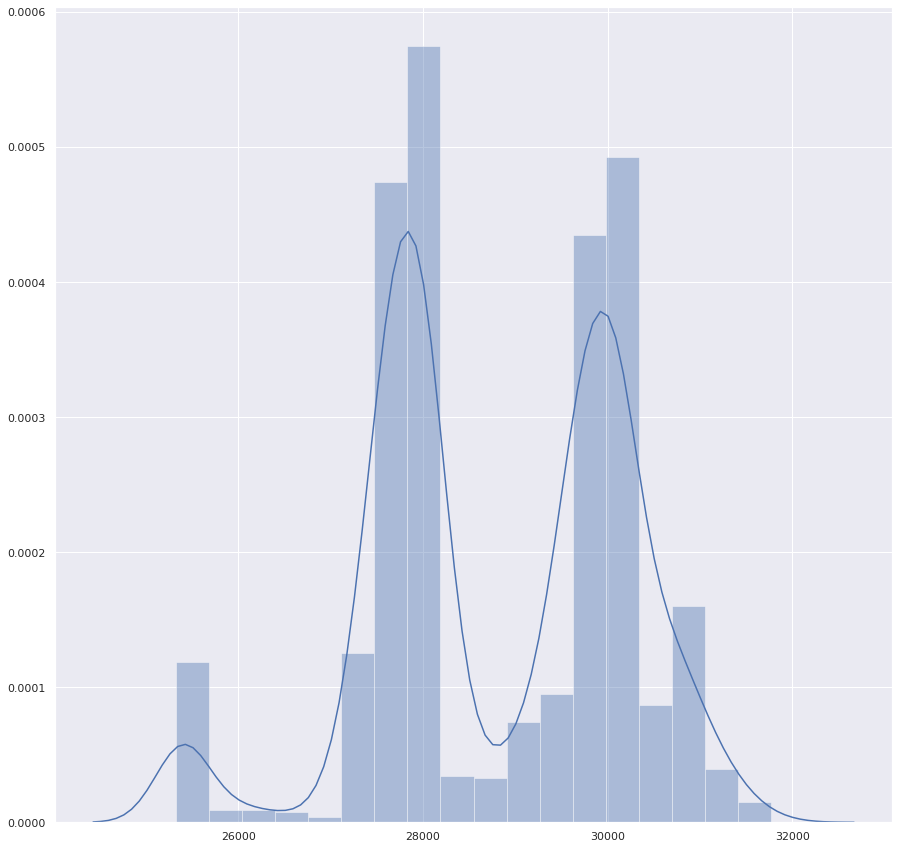

In [7]:
sns.distplot([len(s) for s in cleaned_df['seq']])

## 2. Label 1

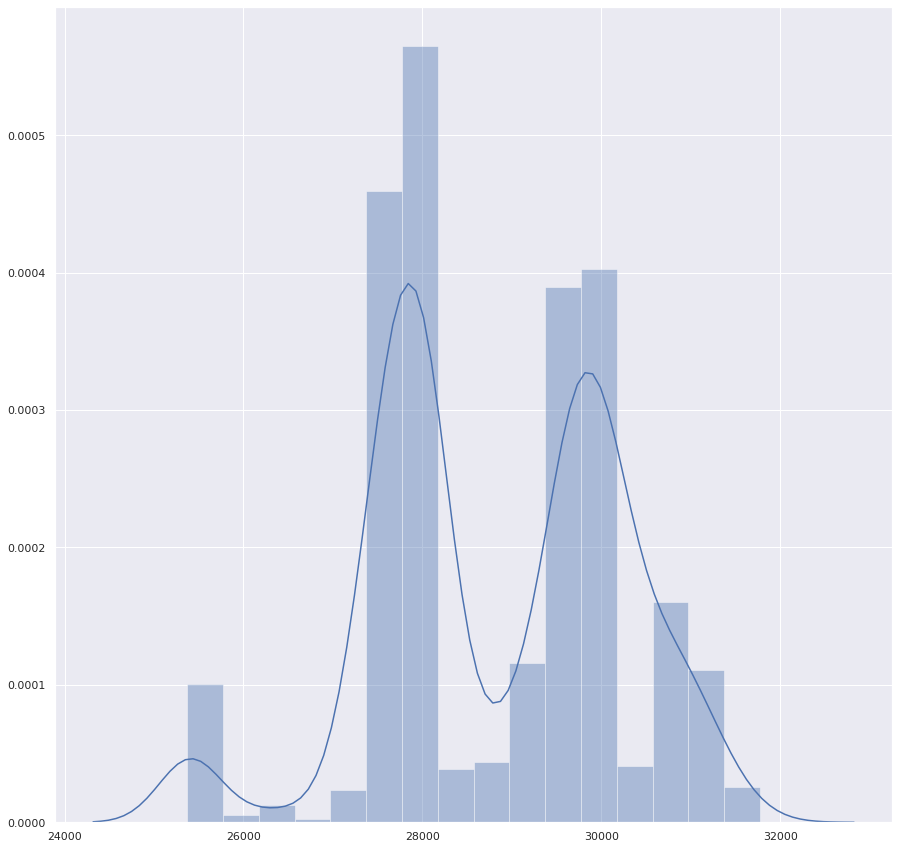

In [11]:
# sequence length distrinution where label is '1'

sns.distplot([len(s) for s in cleaned_df[cleaned_df['label']==1]['seq']])

## 3. Label 2

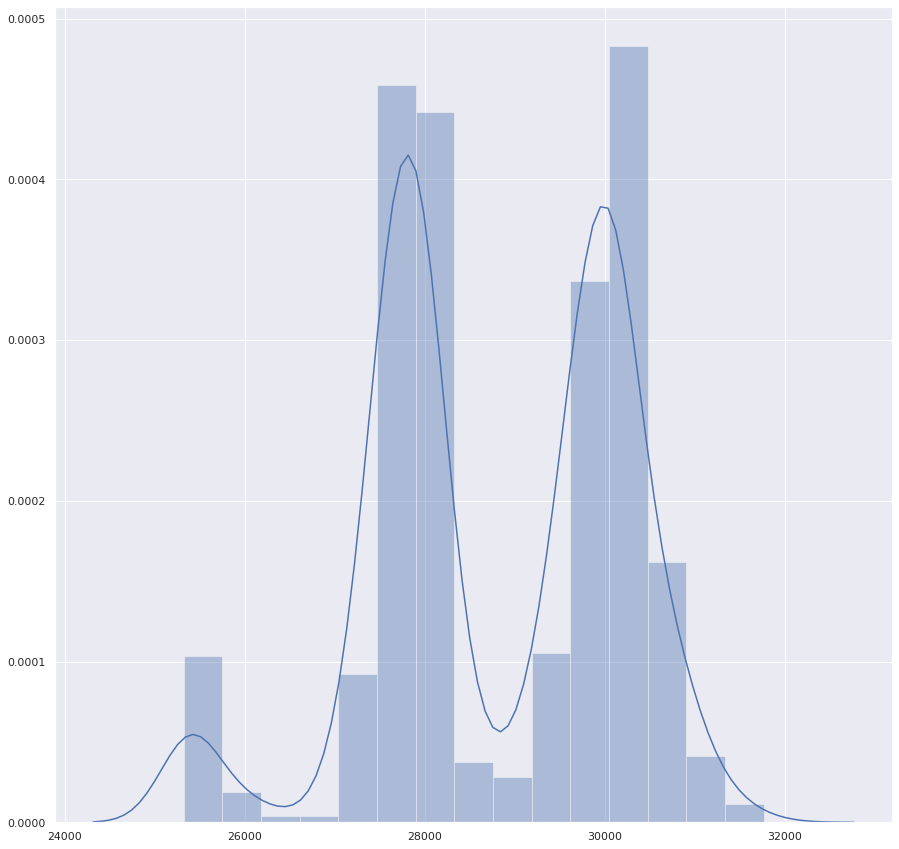

In [9]:
# sequence length distrinution where label is '0'

sns.distplot([len(s) for s in cleaned_df[cleaned_df['label']==0]['seq']])

# Counts of alphabets

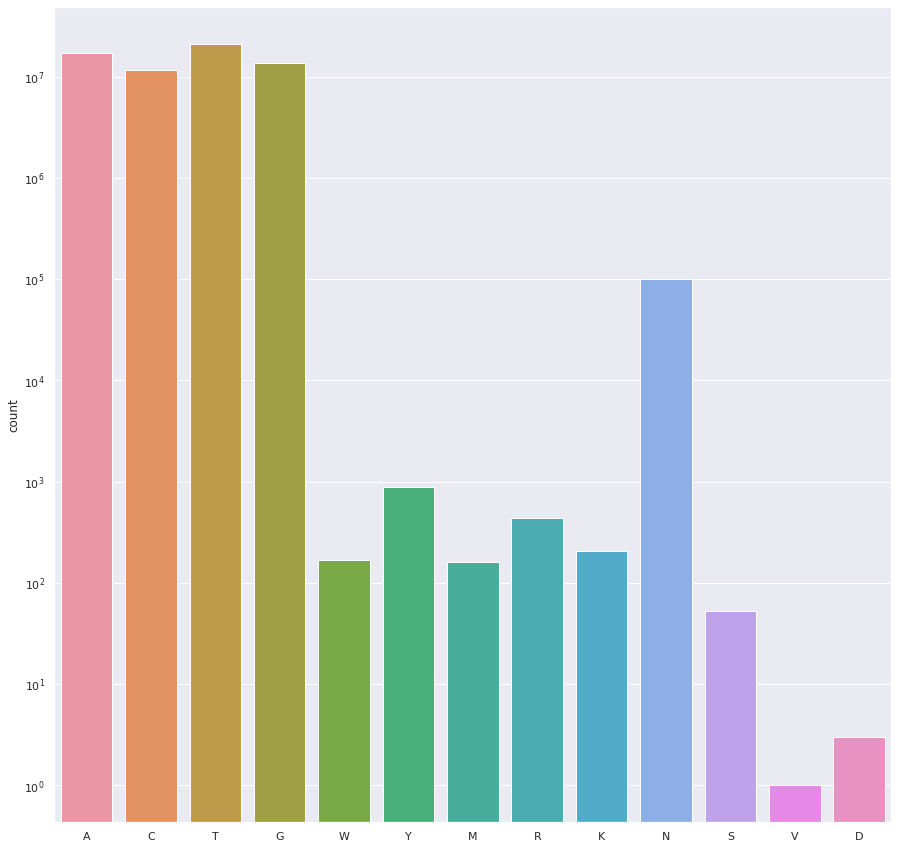

In [14]:
# find letter representations
letters = []
[letters.extend(list(i)) for i in  cleaned_df['seq']]
len_letters = len(set(letters))
len_letters
g = sns.countplot(letters)
g.set_yscale("log")